In [150]:
import mozo2 

import importlib
importlib.reload(mozo2)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mozo import compare_and_combine_2, Diff, merge_with_features, num_to_range_categories
import pandas as pd
import numpy as np
np.random.seed(0)

import xgboost as xgb

from scipy import stats
import math 
import datetime 

from sklearn.metrics import r2_score, mean_absolute_error
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
from sklearn.svm import SVC

from sklearn.metrics import r2_score, f1_score, mean_absolute_error, mean_squared_error

from scikitplot.estimators import plot_learning_curve

import time
from datetime import datetime


print_plots_by_type(total, type =[np.object])

In [3]:
## modelowanie

In [160]:
# import warnings
# warnings.filterwarnings("ignore")

total = pd.read_csv('~/pml7/konkurs/output/newest_total_20201101_19_39.h5.csv')
total.info(verbose=True)

train_30 = pd.read_hdf('output/train_30.h5', 'data') 
test_car_ids = train_30['car_id'].values

train_70 = total[~total['car_id'].isin(test_car_ids) & ~total['price_value'].isna()]
train_30 = total[total['car_id'].isin(test_car_ids)]

print(len(total.index))
print(len(total[~total['price_value'].isna()].index))

print(train_70['price_value'].isna().sum())
print(train_30['price_value'].isna().sum())

train_100 = total[~total['price_value'].isna()]
print(train_100['price_value'].isna().sum())

global_min = total[~total['price_value'].isna()].price_value.min()

test = total[total['price_value'].isna()]
train = total[~total['price_value'].isna()]

train_70_out = train_70.loc[(train_70['is_outlier'] == False)]


/home/conda/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,86,161) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 228 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   breadcrumb                                                object 
 1   created_at                                                object 
 2   price_currency                                            object 
 3   price_details                                             object 
 4   price_value                                               float64
 5   seller_address                                            object 
 6   seller_name                                               object 
 7   seller_type                                               object 
 8   feature_czujniki_parkowania_przednie                      bool   
 9   feature_poduszka_powietrzna_chroniąca_kolana              bool   
 10  feature_kurtyny_powietrzne     

160616
106494
0
0
0


In [3]:
total['out_price_value']

2

In [179]:
from scipy import stats
# total[(np.abs(stats.zscore(total[['price_value']])) < 2).all(axis=1)]

# train_100['out_param_rok_produkcji'] = False
out_param_rok_produkcji = total.loc[np.abs(stats.zscore(total[['param_rok_produkcji']])) > 25.0, 'car_id'].values
print(len(out_param_rok_produkcji))
out_param_moc = total.loc[np.abs(stats.zscore(total[['param_moc']])) > 2, 'car_id'].values
print(len(out_param_moc))
out_param_pojemność_skokowa = total.loc[np.abs(stats.zscore(total[['param_pojemność_skokowa']])) > 11, 'car_id'].values
print(len(out_param_pojemność_skokowa))
out_param_emisja_co2_2 = total.loc[np.abs(stats.zscore(total[['param_emisja_co2_2']])) >1, 'car_id'].values
print(len(out_param_emisja_co2_2))

out_model_8790 = total.loc[np.abs(stats.zscore(total[['model_8790']])) >11, 'car_id'].values
print(len(out_model_8790))

out_latitude_na_mean = total.loc[np.abs(stats.zscore(total[['latitude_na_mean']])) >3, 'car_id'].values
print(len(out_latitude_na_mean))
out_longitude_na_mean = total.loc[np.abs(stats.zscore(total[['longitude_na_mean']])) >3, 'car_id'].values
print(len(out_longitude_na_mean))

total['out_param_rok_produkcji'] = False
total['out_param_moc'] = False
total['out_param_pojemność_skokowa']  = False     
total['out_param_emisja_co2_2'] = False
total['out_model_8790'] = False
total['out_latitude_na_mean']= False
total['out_longitude_na_mean'] = False
# out_param_rok_produkcji

total.loc[total['car_id'].isin(out_param_rok_produkcji), 'out_param_rok_produkcji'] = True
total.loc[total['car_id'].isin(out_param_moc), 'out_param_moc'] = True
total.loc[total['car_id'].isin(out_param_pojemność_skokowa), 'out_param_pojemność_skokowa'] = True
total.loc[total['car_id'].isin(out_param_emisja_co2_2), 'out_param_emisja_co2_2'] = True
total.loc[total['car_id'].isin(out_model_8790), 'out_model_8790'] = True
total.loc[total['car_id'].isin(out_latitude_na_mean), 'out_latitude_na_mean'] = True
total.loc[total['car_id'].isin(out_longitude_na_mean), 'out_longitude_na_mean'] = True

total['is_outlier'] = False

total.loc[(total['out_param_rok_produkcji'] == True) 
          | (total['out_param_moc'] == True)
          | (total['out_param_pojemność_skokowa'] == True)
          | (total['out_param_emisja_co2_2'] == True)
          | (total['out_model_8790'] == True)
          | (total['out_latitude_na_mean'] == True)
          | (total['out_longitude_na_mean'] == True)
         , 'is_outlier'] = True

total.loc[(total['is_outlier'] == True) ]
mozo2.save_dataframe_total(total)

161
39
158
4
21
33
43


In [156]:
train_70_out = train_70.loc[(train_70['is_outlier'] == False)]
train_70_out

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki_parkowania_przednie,feature_poduszka_powietrzna_chroniąca_kolana,...,model_XGBRegressor_2586_45173_oryg_bo_w_trakcie_hiperopt,model_XGBRegressor_2586_45173_,out_param_rok_produkcji,out_param_moc,out_param_pojemność_skokowa,out_param_emisja_co2_2,out_model_8790,out_latitude_na_mean,out_longitude_na_mean,is_outlier
3,"['Osobowe', 'Peugeot', '308', 'Peugeot 308 T7 ...","08:46, 3 marca 2018",PLN,"Cena Brutto, Do negocjacji",19500.0,"Limanowa, limanowski, Małopolskie",NaN,Osoba prywatna,False,False,...,19795.056641,19795.056641,False,False,False,False,False,False,False,False
4,"['Osobowe', 'Volkswagen', 'Golf', 'Volkswagen ...","20:00, 3 marca 2018",PLN,"Cena Brutto, Faktura VAT",164900.0,"Niciarniana 51/53 - 92-320 Łódź, Śródmieście (...",KROTOSKI-CICHY Niciarniana 51/53 oraz Dąbrowsk...,Dealer,True,True,...,172850.203125,172850.203125,False,False,False,False,False,False,False,False
5,"['Osobowe', 'Škoda', 'Octavia', 'Škoda Octavia...","10:42, 5 marca 2018",PLN,"Cena Brutto, Do negocjacji",26900.0,"ALEJA WOLNOŚCI 17E - 63-230 Witaszyce, jarociń...",CREAUTO PIOTR GRUSZCZYŃSKI,Dealer,False,False,...,26687.607422,26687.607422,False,False,False,False,False,False,False,False
7,"['Osobowe', 'Renault', 'Laguna', 'Renault Lagu...","13:45, 5 marca 2018",PLN,"Cena Brutto, Do negocjacji, Faktura VAT",44999.0,"Wielicka 87A - 30-552 Kraków, Podgórze (Polska)",Autoremo Spółka Jawna Andrzej i Edward Kuchta,Dealer,True,False,...,47087.089844,47087.089844,False,False,False,False,False,False,False,False
8,"['Osobowe', 'Volkswagen', 'Golf Plus']","11:46, 28 lutego 2018",PLN,"Cena Brutto, Do negocjacji",17500.0,"Góra, górowski, Dolnośląskie",NaN,Osoba prywatna,False,False,...,17537.699219,17537.699219,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106488,"['Osobowe', 'Audi', 'A3', 'Audi A3 8V (2012-)']","12:03, 4 marca 2018",PLN,"Cena Brutto, Faktura VAT",120300.0,"Niciarniana 51/53 - 92-320 Łódź, Łódzkie (Polska)",Salon Audi Łódź Krotoski Cichy,Dealer,True,True,...,121140.257812,121140.257812,False,False,False,False,False,False,False,False
106490,"['Osobowe', 'Škoda', 'RAPID']","16:23, 22 lutego 2018",PLN,"Cena Netto, Faktura VAT",22700.0,"Modlińska 253b - 03-120 Warszawa, Mazowieckie ...",TIV-AUTO Modlińska253b SALON BEZWYPADKOWYCH WY...,Dealer,False,False,...,22610.394531,22610.394531,False,False,False,False,False,False,False,False
106491,"['Osobowe', 'Opel', 'Zafira', 'Opel Zafira B (...","21:12, 3 marca 2018",PLN,"Cena Brutto, Do negocjacji",15500.0,"Rzeszów, Podkarpackie",NaN,Osoba prywatna,False,True,...,15205.039062,15205.039062,False,False,False,False,False,False,False,False
106492,"['Osobowe', 'Volkswagen', 'Passat', 'Volkswage...","16:10, 28 lutego 2018",PLN,"Cena Brutto, Do negocjacji",6490.0,"Katowicka 112 - 41-705 Ruda Śląska, Śląskie (P...",Auto Komis,Dealer,True,False,...,6454.553223,6454.553223,False,False,False,False,False,False,False,False


mozo2.print_plots_by_type(total, type = [np.number, bool], min_c = 9.0, max_c = 100., max_values=30)

In [173]:
out_price_value = train_70_out.loc[np.abs(stats.zscore(train_70_out[['price_value']])) > 3.5, 'car_id'].values
print(len(out_price_value))
train_70_out['out_price_value'] = False
train_70_out.loc[total['car_id'].isin(out_price_value), 'out_price_value'] = True


1233


/home/conda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/conda/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [175]:
train_70_out_price_outs = train_70_out.loc[(train_70_out['out_price_value'] == False)]


mea: 4592.134301799611
r2: 0.8532232769560854
Learning curve for: XGBRegressor


/home/m.mozolewski_3736/pml7/konkurs/mozo2.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['price_value'] = y_pred


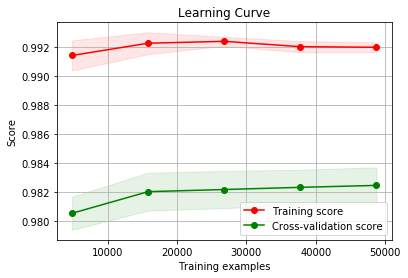

In [177]:
start_vars = np.sort([
#2510.5911186788753
#     'encoded_param_napęd_2', 'encoded_param_rodzaj_paliwa_2', 'feature_abs', 'feature_asystent_parkowania', 'feature_centralny_zamek', 'feature_czujnik_deszczu', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_hud__wyświetlacz_przezierny_', 'feature_klimatyzacja_manualna', 'feature_mp3', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogranicznik_prędkości', 'feature_ogrzewanie_postojowe', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_przyciemniane_szyby', 'feature_radio_fabryczne', 'feature_regulowane_zawieszenie', 'feature_tapicerka_skórzana', 'feature_wielofunkcyjna_kierownica', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_stan_cat', 'new_param_wersja_cat', 'new_seller_type_cat', 'new_seller_wojewodzctwo_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'param_bezwypadkowy', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_liczba_miejsc_2', 'param_liczba_pozostałych_rat_2', 'param_miesięczna_rata_2', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_date_na', 'param_przebieg', 'param_serwisowany_w_aso', 'param_vin_len'
#2530.5062369070815
#     'encoded_param_napęd_2', 'encoded_param_typ_2', 'feature_alarm', 'feature_alufelgi', 'feature_centralny_zamek', 'feature_czujnik_zmierzchu', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_esp__stabilizacja_toru_jazdy_', 'feature_gniazdo_usb', 'feature_hak', 'feature_hud__wyświetlacz_przezierny_', 'feature_klimatyzacja_dwustrefowa', 'feature_kurtyny_powietrzne', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogrzewanie_postojowe', 'feature_podgrzewane_lusterka_boczne', 'feature_podgrzewane_przednie_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_regulowane_zawieszenie', 'feature_szyberdach', 'feature_tapicerka_skórzana', 'feature_tapicerka_welurowa', 'feature_tempomat', 'feature_tempomat_aktywny', 'feature_tuner_tv', 'feature_zmieniarka_cd', 'feature_łopatki_zmiany_biegów', 'feature_światła_do_jazdy_dziennej', 'model_8790', 'new_param_kategoria_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_oferta_od_cat', 'new_param_skrzynia_biegów_cat', 'new_param_typ_cat', 'new_param_wartość_wykupu_cat', 'new_vin_plant_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'new_vin_where_cat', 'ogloszenie_dzien_tyg', 'param_akryl__niemetalizowany_', 'param_emisja_co2_2', 'param_liczba_pozostałych_rat_2', 'param_matowy', 'param_perłowy', 'param_pierwsza_rejestracja_ten_rok', 'param_pierwszy_właściciel', 'param_rok_produkcji_10_lat', 'param_vin_len', 'param_zarejestrowany_w_polsce'
#2539.081044523367 OK
#     'encoded_param_napęd_2', 'encoded_param_rodzaj_paliwa_2', 'feature_asystent_parkowania', 'feature_centralny_zamek', 'feature_czujnik_deszczu', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_hud__wyświetlacz_przezierny_', 'feature_klimatyzacja_manualna', 'feature_mp3', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogranicznik_prędkości', 'feature_ogrzewanie_postojowe', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_przyciemniane_szyby', 'feature_radio_fabryczne', 'feature_regulowane_zawieszenie', 'feature_tapicerka_skórzana', 'feature_wielofunkcyjna_kierownica', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_stan_cat', 'new_param_wersja_cat', 'new_seller_type_cat', 'new_seller_wojewodzctwo_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'param_bezwypadkowy', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_liczba_miejsc_2', 'param_liczba_pozostałych_rat_2', 'param_miesięczna_rata_2', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_date_na', 'param_przebieg', 'param_serwisowany_w_aso', 'param_vin_len'
# 2539.8693654611006 OK
#     'encoded_param_kolor_2', 'encoded_param_napęd_2', 'encoded_param_rodzaj_paliwa_2', 'feature_asystent_pasa_ruchu', 'feature_centralny_zamek', 'feature_czujnik_deszczu', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_gniazdo_aux', 'feature_hud__wyświetlacz_przezierny_', 'feature_immobilizer', 'feature_kamera_cofania', 'feature_mp3', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogrzewanie_postojowe', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_chroniąca_kolana', 'feature_poduszka_powietrzna_kierowcy', 'feature_poduszki_boczne_tylne', 'feature_przyciemniane_szyby', 'feature_radio_fabryczne', 'feature_regulowane_zawieszenie', 'feature_szyberdach', 'feature_tapicerka_skórzana', 'feature_tuner_tv', 'feature_wielofunkcyjna_kierownica', 'feature_światła_led', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_oferta_od_cat', 'new_param_opłata_początkowa_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_vin_cat', 'new_param_wartość_wykupu_cat', 'new_vin_flex_fuel_cat', 'new_vin_portrait_cat', 'new_vin_where_cat', 'ogloszenie_dni_wisi', 'ogloszenie_miesiac', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_kierownica_po_prawej__anglik_', 'param_metalik', 'param_moc', 'param_przebieg', 'param_rok_produkcji_10_lat', 'param_serwisowany_w_aso', 'price_currency_pln'
# 2522.5684193122147
#     'encoded_param_napęd_2', 'encoded_param_rodzaj_paliwa_2', 'encoded_param_typ_2', 'feature_asystent_parkowania', 'feature_centralny_zamek', 'feature_czujnik_deszczu', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_hud__wyświetlacz_przezierny_', 'feature_klimatyzacja_manualna', 'feature_mp3', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogranicznik_prędkości', 'feature_ogrzewanie_postojowe', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_przyciemniane_szyby', 'feature_radio_fabryczne', 'feature_regulowane_zawieszenie', 'feature_tapicerka_skórzana', 'feature_wielofunkcyjna_kierownica', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_stan_cat', 'new_param_wersja_cat', 'new_seller_type_cat', 'new_seller_wojewodzctwo_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'param_bezwypadkowy', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_liczba_miejsc_2', 'param_liczba_pozostałych_rat_2', 'param_miesięczna_rata_2', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_date_na', 'param_przebieg', 'param_serwisowany_w_aso', 'param_vin_len'
# 2526.659816396989
#     'encoded_param_napęd_2', 'encoded_param_rodzaj_paliwa_2', 'encoded_param_skrzynia_biegów_2', 'feature_asystent_parkowania', 'feature_centralny_zamek', 'feature_czujnik_deszczu', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_hud__wyświetlacz_przezierny_', 'feature_klimatyzacja_manualna', 'feature_mp3', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogranicznik_prędkości', 'feature_ogrzewanie_postojowe', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_przyciemniane_szyby', 'feature_radio_fabryczne', 'feature_regulowane_zawieszenie', 'feature_tapicerka_skórzana', 'feature_wielofunkcyjna_kierownica', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_stan_cat', 'new_param_wersja_cat', 'new_seller_type_cat', 'new_seller_wojewodzctwo_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'param_bezwypadkowy', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_liczba_miejsc_2', 'param_liczba_pozostałych_rat_2', 'param_miesięczna_rata_2', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_date_na', 'param_przebieg', 'param_serwisowany_w_aso', 'param_vin_len'
# 2604.46495618895
#     'encoded_param_rodzaj_paliwa_2', 'feature_abs', 'feature_bluetooth', 'feature_centralny_zamek', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_gniazdo_sd', 'feature_immobilizer', 'feature_isofix', 'feature_klimatyzacja_automatyczna', 'feature_klimatyzacja_manualna', 'feature_komputer_pokładowy', 'feature_ogrzewanie_postojowe', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_radio_fabryczne', 'feature_szyberdach', 'feature_tapicerka_skórzana', 'feature_tempomat', 'feature_wielofunkcyjna_kierownica', 'feature_zmieniarka_cd', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'model_8790', 'new_param_kategoria_cat', 'new_param_kolor_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_marka_pojazdu_cat', 'new_param_model_pojazdu_cat', 'new_param_oferta_od_cat', 'new_param_opłata_początkowa_cat', 'new_seller_name_cat', 'new_vin_flex_fuel_cat', 'new_vin_model_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'ogloszenie_rok', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_homologacja_ciężarowa', 'param_ile_lat_temu_produkcja', 'param_liczba_pozostałych_rat_2', 'param_matowy', 'param_metalik', 'param_moc', 'param_perłowy', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_ten_rok', 'param_przebieg', 'param_serwisowany_w_aso', 'param_tuning'
# 2614.699240661753
#     'encoded_param_rodzaj_paliwa_2', 'feature_abs', 'feature_bluetooth', 'feature_centralny_zamek', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_gniazdo_sd', 'feature_immobilizer', 'feature_isofix', 'feature_klimatyzacja_automatyczna', 'feature_klimatyzacja_manualna', 'feature_komputer_pokładowy', 'feature_ogrzewanie_postojowe', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_radio_fabryczne', 'feature_szyberdach', 'feature_tapicerka_skórzana', 'feature_tempomat', 'feature_wielofunkcyjna_kierownica', 'feature_zmieniarka_cd', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'model_8790', 'new_param_kategoria_cat', 'new_param_kolor_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_marka_pojazdu_cat', 'new_param_model_pojazdu_cat', 'new_param_oferta_od_cat', 'new_param_opłata_początkowa_cat', 'new_seller_name_cat', 'new_vin_flex_fuel_cat', 'new_vin_model_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'ogloszenie_rok', 'param_bezwypadkowy', 'param_filtr_cząstek_stałych', 'param_homologacja_ciężarowa', 'param_ile_lat_temu_produkcja', 'param_liczba_pozostałych_rat_2', 'param_matowy', 'param_metalik', 'param_moc', 'param_perłowy', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_ten_rok', 'param_przebieg', 'param_serwisowany_w_aso', 'param_tuning'
# 2608.375895255625 sliczny -> 2586.451733203424 -> 2971.787393244852 (900)
    'created_at_unix', 'encoded_param_rodzaj_paliwa_2', 'encoded_param_typ_2', 'feature_abs', 'feature_asr__kontrola_trakcji_', 'feature_bluetooth', 'feature_cd', 'feature_czujniki_parkowania_przednie', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_gniazdo_sd', 'feature_hud__wyświetlacz_przezierny_', 'feature_isofix', 'feature_klimatyzacja_automatyczna', 'feature_klimatyzacja_manualna', 'feature_ogrzewanie_postojowe', 'feature_podgrzewane_tylne_siedzenia', 'feature_relingi_dachowe', 'feature_tapicerka_skórzana', 'feature_tapicerka_welurowa', 'feature_tempomat', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'latitude_na_mean', 'longitude', 'longitude_na_mean', 'model_8790', 'new_param_kolor_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_marka_pojazdu_cat', 'new_param_oferta_od_cat', 'new_param_opłata_początkowa_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_wersja_cat', 'new_seller_name_cat', 'new_vin_flex_fuel_cat', 'new_vin_model_cat', 'new_vin_security_cat', 'param_bezwypadkowy', 'param_homologacja_ciężarowa', 'param_ile_lat_temu_produkcja', 'param_leasing', 'param_liczba_miejsc_2', 'param_liczba_pozostałych_rat_2', 'param_matowy', 'param_przebieg', 'param_rok_produkcji', 'param_tuning', 'param_uszkodzony', 'param_wartość_wykupu_2'
# 2520.234407465377 OK
#     'created_at_unix', 'created_at_unix_na_mean', 'encoded_param_napęd_2', 'encoded_param_typ_2', 'feature_asr__kontrola_trakcji_', 'feature_czujnik_zmierzchu', 'feature_czujniki_parkowania_przednie', 'feature_czujniki_parkowania_tylne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_isofix', 'feature_klimatyzacja_czterostrefowa', 'feature_klimatyzacja_dwustrefowa', 'feature_komputer_pokładowy', 'feature_ogranicznik_prędkości', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_przednie_siedzenia', 'feature_poduszka_powietrzna_pasażera', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_radio_niefabryczne', 'feature_relingi_dachowe', 'feature_szyberdach', 'feature_tapicerka_welurowa', 'feature_tuner_tv', 'feature_wspomaganie_kierownicy', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_opłata_początkowa_cat', 'new_param_stan_cat', 'new_seller_name_cat', 'new_vin_security_cat', 'ogloszenie_rok', 'param_emisja_co2_2', 'param_leasing', 'param_miesięczna_rata_2', 'param_możliwość_finansowania', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_ten_rok', 'param_przebieg', 'param_rok_produkcji', 'param_rok_produkcji_10_lat', 'param_rok_produkcji_poprzedni_rok', 'param_tuning', 'param_vat_discount', 'param_wartość_wykupu_2', 'param_zarejestrowany_jako_zabytek'
# 2522.7314130633035 OK
#     'created_at_unix', 'created_at_unix_na_mean', 'encoded_param_napęd_2', 'encoded_param_typ_2', 'feature_asr__kontrola_trakcji_', 'feature_czujnik_zmierzchu', 'feature_czujniki_parkowania_przednie', 'feature_czujniki_parkowania_tylne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_isofix', 'feature_klimatyzacja_czterostrefowa', 'feature_klimatyzacja_dwustrefowa', 'feature_komputer_pokładowy', 'feature_ogranicznik_prędkości', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_przednie_siedzenia', 'feature_poduszka_powietrzna_pasażera', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_radio_niefabryczne', 'feature_relingi_dachowe', 'feature_szyberdach', 'feature_tapicerka_welurowa', 'feature_tuner_tv', 'feature_wspomaganie_kierownicy', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_opłata_początkowa_cat', 'new_param_stan_cat', 'new_seller_name_cat', 'new_vin_security_cat', 'ogloszenie_rok', 'param_emisja_co2_2', 'param_leasing', 'param_miesięczna_rata_2', 'param_możliwość_finansowania', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_ten_rok', 'param_przebieg', 'param_rok_produkcji', 'param_rok_produkcji_10_lat', 'param_rok_produkcji_poprzedni_rok', 'param_vat_discount', 'param_vat_free', 'param_wartość_wykupu_2', 'param_zarejestrowany_jako_zabytek'
    
])

# params = {    
#     'n_jobs': 12, 

#     'n_estimators': 90, 
#     'learning_rate': 0.1, 
#     'subsample': 0.5, 
#     'colsample_bytree': 0.9,
#     'max_depth': 10, 
# }

params = {    
        "n_estimators": 90,##wiecej czy pomaga = ladniuejszy wykres
        "colsample_bytree": 0.9977314361800289,
        "learning_rate": 0.12918308385376528,
        "max_depth": 29,
        "min_child_weight": 50,
        "random_state": 950,
        "reg_alpha": 1.732596305325749,
        "reg_lambda": 0.3572913121907399,
        "subsample": 0.999649854200746
}


mae, r2, model, model_cl, learning_curve_plot = mozo2.train_and_submit(train_70_out_price_outs, train_30, total.loc[total['price_value'].isna(),], 
             start_vars, global_min, 
             xgb.XGBRegressor, params, digitize=None, subfolder='learning_curves',
             file_sufix = 'model_2586_na_train_70_out', opis='train_70_out, z modelu 2586.451733203424', 
             learning_curve = True, 
             add_model_column_min = 5000, total = total, 
             save_min=5000, kaggle_min=-1)


mea: 2523.5700177017043
r2: 0.9779020843972883
Learning curve for: XGBRegressor


/home/m.mozolewski_3736/pml7/konkurs/mozo2.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['price_value'] = y_pred


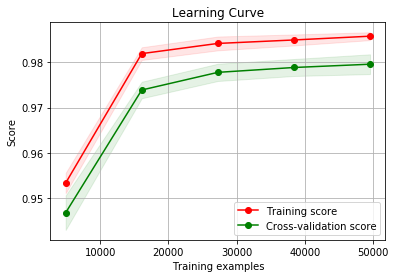

In [178]:
start_vars = np.sort([
#2510.5911186788753
#     'encoded_param_napęd_2', 'encoded_param_rodzaj_paliwa_2', 'feature_abs', 'feature_asystent_parkowania', 'feature_centralny_zamek', 'feature_czujnik_deszczu', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_hud__wyświetlacz_przezierny_', 'feature_klimatyzacja_manualna', 'feature_mp3', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogranicznik_prędkości', 'feature_ogrzewanie_postojowe', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_przyciemniane_szyby', 'feature_radio_fabryczne', 'feature_regulowane_zawieszenie', 'feature_tapicerka_skórzana', 'feature_wielofunkcyjna_kierownica', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_stan_cat', 'new_param_wersja_cat', 'new_seller_type_cat', 'new_seller_wojewodzctwo_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'param_bezwypadkowy', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_liczba_miejsc_2', 'param_liczba_pozostałych_rat_2', 'param_miesięczna_rata_2', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_date_na', 'param_przebieg', 'param_serwisowany_w_aso', 'param_vin_len'
#2530.5062369070815
#     'encoded_param_napęd_2', 'encoded_param_typ_2', 'feature_alarm', 'feature_alufelgi', 'feature_centralny_zamek', 'feature_czujnik_zmierzchu', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_esp__stabilizacja_toru_jazdy_', 'feature_gniazdo_usb', 'feature_hak', 'feature_hud__wyświetlacz_przezierny_', 'feature_klimatyzacja_dwustrefowa', 'feature_kurtyny_powietrzne', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogrzewanie_postojowe', 'feature_podgrzewane_lusterka_boczne', 'feature_podgrzewane_przednie_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_regulowane_zawieszenie', 'feature_szyberdach', 'feature_tapicerka_skórzana', 'feature_tapicerka_welurowa', 'feature_tempomat', 'feature_tempomat_aktywny', 'feature_tuner_tv', 'feature_zmieniarka_cd', 'feature_łopatki_zmiany_biegów', 'feature_światła_do_jazdy_dziennej', 'model_8790', 'new_param_kategoria_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_oferta_od_cat', 'new_param_skrzynia_biegów_cat', 'new_param_typ_cat', 'new_param_wartość_wykupu_cat', 'new_vin_plant_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'new_vin_where_cat', 'ogloszenie_dzien_tyg', 'param_akryl__niemetalizowany_', 'param_emisja_co2_2', 'param_liczba_pozostałych_rat_2', 'param_matowy', 'param_perłowy', 'param_pierwsza_rejestracja_ten_rok', 'param_pierwszy_właściciel', 'param_rok_produkcji_10_lat', 'param_vin_len', 'param_zarejestrowany_w_polsce'
#2539.081044523367 OK
#     'encoded_param_napęd_2', 'encoded_param_rodzaj_paliwa_2', 'feature_asystent_parkowania', 'feature_centralny_zamek', 'feature_czujnik_deszczu', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_hud__wyświetlacz_przezierny_', 'feature_klimatyzacja_manualna', 'feature_mp3', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogranicznik_prędkości', 'feature_ogrzewanie_postojowe', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_przyciemniane_szyby', 'feature_radio_fabryczne', 'feature_regulowane_zawieszenie', 'feature_tapicerka_skórzana', 'feature_wielofunkcyjna_kierownica', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_stan_cat', 'new_param_wersja_cat', 'new_seller_type_cat', 'new_seller_wojewodzctwo_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'param_bezwypadkowy', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_liczba_miejsc_2', 'param_liczba_pozostałych_rat_2', 'param_miesięczna_rata_2', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_date_na', 'param_przebieg', 'param_serwisowany_w_aso', 'param_vin_len'
# 2539.8693654611006 OK
#     'encoded_param_kolor_2', 'encoded_param_napęd_2', 'encoded_param_rodzaj_paliwa_2', 'feature_asystent_pasa_ruchu', 'feature_centralny_zamek', 'feature_czujnik_deszczu', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_gniazdo_aux', 'feature_hud__wyświetlacz_przezierny_', 'feature_immobilizer', 'feature_kamera_cofania', 'feature_mp3', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogrzewanie_postojowe', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_chroniąca_kolana', 'feature_poduszka_powietrzna_kierowcy', 'feature_poduszki_boczne_tylne', 'feature_przyciemniane_szyby', 'feature_radio_fabryczne', 'feature_regulowane_zawieszenie', 'feature_szyberdach', 'feature_tapicerka_skórzana', 'feature_tuner_tv', 'feature_wielofunkcyjna_kierownica', 'feature_światła_led', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_oferta_od_cat', 'new_param_opłata_początkowa_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_vin_cat', 'new_param_wartość_wykupu_cat', 'new_vin_flex_fuel_cat', 'new_vin_portrait_cat', 'new_vin_where_cat', 'ogloszenie_dni_wisi', 'ogloszenie_miesiac', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_kierownica_po_prawej__anglik_', 'param_metalik', 'param_moc', 'param_przebieg', 'param_rok_produkcji_10_lat', 'param_serwisowany_w_aso', 'price_currency_pln'
# 2522.5684193122147
#     'encoded_param_napęd_2', 'encoded_param_rodzaj_paliwa_2', 'encoded_param_typ_2', 'feature_asystent_parkowania', 'feature_centralny_zamek', 'feature_czujnik_deszczu', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_hud__wyświetlacz_przezierny_', 'feature_klimatyzacja_manualna', 'feature_mp3', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogranicznik_prędkości', 'feature_ogrzewanie_postojowe', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_przyciemniane_szyby', 'feature_radio_fabryczne', 'feature_regulowane_zawieszenie', 'feature_tapicerka_skórzana', 'feature_wielofunkcyjna_kierownica', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_stan_cat', 'new_param_wersja_cat', 'new_seller_type_cat', 'new_seller_wojewodzctwo_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'param_bezwypadkowy', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_liczba_miejsc_2', 'param_liczba_pozostałych_rat_2', 'param_miesięczna_rata_2', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_date_na', 'param_przebieg', 'param_serwisowany_w_aso', 'param_vin_len'
# 2526.659816396989
#     'encoded_param_napęd_2', 'encoded_param_rodzaj_paliwa_2', 'encoded_param_skrzynia_biegów_2', 'feature_asystent_parkowania', 'feature_centralny_zamek', 'feature_czujnik_deszczu', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_hud__wyświetlacz_przezierny_', 'feature_klimatyzacja_manualna', 'feature_mp3', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogranicznik_prędkości', 'feature_ogrzewanie_postojowe', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_przyciemniane_szyby', 'feature_radio_fabryczne', 'feature_regulowane_zawieszenie', 'feature_tapicerka_skórzana', 'feature_wielofunkcyjna_kierownica', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_stan_cat', 'new_param_wersja_cat', 'new_seller_type_cat', 'new_seller_wojewodzctwo_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'param_bezwypadkowy', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_liczba_miejsc_2', 'param_liczba_pozostałych_rat_2', 'param_miesięczna_rata_2', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_date_na', 'param_przebieg', 'param_serwisowany_w_aso', 'param_vin_len'
# 2604.46495618895
#     'encoded_param_rodzaj_paliwa_2', 'feature_abs', 'feature_bluetooth', 'feature_centralny_zamek', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_gniazdo_sd', 'feature_immobilizer', 'feature_isofix', 'feature_klimatyzacja_automatyczna', 'feature_klimatyzacja_manualna', 'feature_komputer_pokładowy', 'feature_ogrzewanie_postojowe', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_radio_fabryczne', 'feature_szyberdach', 'feature_tapicerka_skórzana', 'feature_tempomat', 'feature_wielofunkcyjna_kierownica', 'feature_zmieniarka_cd', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'model_8790', 'new_param_kategoria_cat', 'new_param_kolor_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_marka_pojazdu_cat', 'new_param_model_pojazdu_cat', 'new_param_oferta_od_cat', 'new_param_opłata_początkowa_cat', 'new_seller_name_cat', 'new_vin_flex_fuel_cat', 'new_vin_model_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'ogloszenie_rok', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_homologacja_ciężarowa', 'param_ile_lat_temu_produkcja', 'param_liczba_pozostałych_rat_2', 'param_matowy', 'param_metalik', 'param_moc', 'param_perłowy', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_ten_rok', 'param_przebieg', 'param_serwisowany_w_aso', 'param_tuning'
# 2614.699240661753
#     'encoded_param_rodzaj_paliwa_2', 'feature_abs', 'feature_bluetooth', 'feature_centralny_zamek', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_gniazdo_sd', 'feature_immobilizer', 'feature_isofix', 'feature_klimatyzacja_automatyczna', 'feature_klimatyzacja_manualna', 'feature_komputer_pokładowy', 'feature_ogrzewanie_postojowe', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_radio_fabryczne', 'feature_szyberdach', 'feature_tapicerka_skórzana', 'feature_tempomat', 'feature_wielofunkcyjna_kierownica', 'feature_zmieniarka_cd', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'model_8790', 'new_param_kategoria_cat', 'new_param_kolor_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_marka_pojazdu_cat', 'new_param_model_pojazdu_cat', 'new_param_oferta_od_cat', 'new_param_opłata_początkowa_cat', 'new_seller_name_cat', 'new_vin_flex_fuel_cat', 'new_vin_model_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'ogloszenie_rok', 'param_bezwypadkowy', 'param_filtr_cząstek_stałych', 'param_homologacja_ciężarowa', 'param_ile_lat_temu_produkcja', 'param_liczba_pozostałych_rat_2', 'param_matowy', 'param_metalik', 'param_moc', 'param_perłowy', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_ten_rok', 'param_przebieg', 'param_serwisowany_w_aso', 'param_tuning'
# 2608.375895255625 sliczny -> 2586.451733203424 -> 2971.787393244852 (900)
    'created_at_unix', 'encoded_param_rodzaj_paliwa_2', 'encoded_param_typ_2', 'feature_abs', 'feature_asr__kontrola_trakcji_', 'feature_bluetooth', 'feature_cd', 'feature_czujniki_parkowania_przednie', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_gniazdo_sd', 'feature_hud__wyświetlacz_przezierny_', 'feature_isofix', 'feature_klimatyzacja_automatyczna', 'feature_klimatyzacja_manualna', 'feature_ogrzewanie_postojowe', 'feature_podgrzewane_tylne_siedzenia', 'feature_relingi_dachowe', 'feature_tapicerka_skórzana', 'feature_tapicerka_welurowa', 'feature_tempomat', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'latitude_na_mean', 'longitude', 'longitude_na_mean', 'model_8790', 'new_param_kolor_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_marka_pojazdu_cat', 'new_param_oferta_od_cat', 'new_param_opłata_początkowa_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_wersja_cat', 'new_seller_name_cat', 'new_vin_flex_fuel_cat', 'new_vin_model_cat', 'new_vin_security_cat', 'param_bezwypadkowy', 'param_homologacja_ciężarowa', 'param_ile_lat_temu_produkcja', 'param_leasing', 'param_liczba_miejsc_2', 'param_liczba_pozostałych_rat_2', 'param_matowy', 'param_przebieg', 'param_rok_produkcji', 'param_tuning', 'param_uszkodzony', 'param_wartość_wykupu_2'
# 2520.234407465377 OK
#     'created_at_unix', 'created_at_unix_na_mean', 'encoded_param_napęd_2', 'encoded_param_typ_2', 'feature_asr__kontrola_trakcji_', 'feature_czujnik_zmierzchu', 'feature_czujniki_parkowania_przednie', 'feature_czujniki_parkowania_tylne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_isofix', 'feature_klimatyzacja_czterostrefowa', 'feature_klimatyzacja_dwustrefowa', 'feature_komputer_pokładowy', 'feature_ogranicznik_prędkości', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_przednie_siedzenia', 'feature_poduszka_powietrzna_pasażera', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_radio_niefabryczne', 'feature_relingi_dachowe', 'feature_szyberdach', 'feature_tapicerka_welurowa', 'feature_tuner_tv', 'feature_wspomaganie_kierownicy', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_opłata_początkowa_cat', 'new_param_stan_cat', 'new_seller_name_cat', 'new_vin_security_cat', 'ogloszenie_rok', 'param_emisja_co2_2', 'param_leasing', 'param_miesięczna_rata_2', 'param_możliwość_finansowania', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_ten_rok', 'param_przebieg', 'param_rok_produkcji', 'param_rok_produkcji_10_lat', 'param_rok_produkcji_poprzedni_rok', 'param_tuning', 'param_vat_discount', 'param_wartość_wykupu_2', 'param_zarejestrowany_jako_zabytek'
# 2522.7314130633035 OK
#     'created_at_unix', 'created_at_unix_na_mean', 'encoded_param_napęd_2', 'encoded_param_typ_2', 'feature_asr__kontrola_trakcji_', 'feature_czujnik_zmierzchu', 'feature_czujniki_parkowania_przednie', 'feature_czujniki_parkowania_tylne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_isofix', 'feature_klimatyzacja_czterostrefowa', 'feature_klimatyzacja_dwustrefowa', 'feature_komputer_pokładowy', 'feature_ogranicznik_prędkości', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_przednie_siedzenia', 'feature_poduszka_powietrzna_pasażera', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_radio_niefabryczne', 'feature_relingi_dachowe', 'feature_szyberdach', 'feature_tapicerka_welurowa', 'feature_tuner_tv', 'feature_wspomaganie_kierownicy', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_opłata_początkowa_cat', 'new_param_stan_cat', 'new_seller_name_cat', 'new_vin_security_cat', 'ogloszenie_rok', 'param_emisja_co2_2', 'param_leasing', 'param_miesięczna_rata_2', 'param_możliwość_finansowania', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_ten_rok', 'param_przebieg', 'param_rok_produkcji', 'param_rok_produkcji_10_lat', 'param_rok_produkcji_poprzedni_rok', 'param_vat_discount', 'param_vat_free', 'param_wartość_wykupu_2', 'param_zarejestrowany_jako_zabytek'

])

params = {    
    'n_jobs': 12, 

    'n_estimators': 90, 
    'learning_rate': 0.1, 
    'subsample': 0.5, 
    'colsample_bytree': 0.9,
    'max_depth': 10, 
}

params = {    
        "max_depth": 78,
        "n_estimators": 90,
        "colsample_bytree": 0.9788858599411533,
        "learning_rate": 0.08183084006930927,
        "subsample": 0.6077157503574224,
        "random_state": 5250,
        "min_child_weight": 48,
        "reg_alpha": 1.6787552166433444,
        "reg_lambda": 0.7013163968001613,
        "objective": "reg:squarederror"
}


mae, r2, model, model_cl, learning_curve_plot = mozo2.train_and_submit(train_70_out, train_30, total.loc[total['price_value'].isna(),], 
             start_vars, global_min, 
             xgb.XGBRegressor, params, digitize=None, subfolder='learning_curves',
             file_sufix = 'oryg_bo_w_trakcie_hiperopt', opis='', 
             learning_curve = True, 
             add_model_column_min = 3000, total = total, 
             save_min=4000, kaggle_min=-1)


In [69]:
save_dataframe_total()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 218 columns):
 #   Column                                                  Dtype  
---  ------                                                  -----  
 0   breadcrumb                                              object 
 1   created_at                                              object 
 2   price_currency                                          object 
 3   price_details                                           object 
 4   price_value                                             float64
 5   seller_address                                          object 
 6   seller_name                                             object 
 7   seller_type                                             object 
 8   feature_czujniki_parkowania_przednie                    bool   
 9   feature_poduszka_powietrzna_chroniąca_kolana            bool   
 10  feature_kurtyny_powietrzne                             

In [6]:
# model = RandomForestRegressor(n_estimators=50, max_depth=7).fit(X_sub_train, y_sub_train) 
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC

shift = 0

perm = PermutationImportance(model).fit(train_30[ start_vars ], (np.log(train_30['price_value'].values) - shift)) 
eli5.show_weights(perm, feature_names=random_feats, top=50) 


/home/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51'] ['encoded_param_napęd_2', 'encoded_param_rodzaj_paliwa_2', 'feature_abs', 'feature_asystent_parkowania', 'feature_centralny_zamek', 'feature_czujnik_deszczu', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_hud__wyświetlacz_przezierny_', 'feature_klimatyzacja_manualna', 'feature_mp3', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_ogranicznik_prędkości', 'feature_ogrzewanie_postojowe', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_tylne_siedzenia', 'feature_poduszka_powietrzna_kierowcy', 'feature_poduszki_boczne_przednie', 'feature_poduszki_boczne_tylne', 'feature_przyciemniane_szyby', 'feature_radio_fabryczne', 'feature_regulowane_zawieszenie', 'feature_tapicerka_skórzana', 'feature_wielofunkcyjna_kierownica', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'model_8790', 'new_param_emisja_co2_cat', 'new_param_kategoria_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_stan_cat', 'new_param_wersja_cat', 'new_seller_type_cat', 'new_seller_wojewodzctwo_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'param_bezwypadkowy', 'param_faktura_vat', 'param_filtr_cząstek_stałych', 'param_liczba_miejsc_2', 'param_liczba_pozostałych_rat_2', 'param_miesięczna_rata_2', 'param_pierwsza_rejestracja_10_lat', 'param_pierwsza_rejestracja_date_na', 'param_przebieg', 'param_serwisowany_w_aso', 'param_vin_len']
expected f34, f51, f43, f31, f32, f24, f11, f30, f37, f38, f12, f39, f20, f42, f19, f2, f50, f3, f27, f48, f35, f7, f29, f4, f9, f14, f36, f46, f16, f47, f5, f6, f15, f28, f21, f40, f33, f22, f17, f13, f44, f45, f23, f41, f18, f0, f8, f25, f26, f1, f10, f49 in input data
training data did not have the following fields: feature_poduszki_boczne_przednie, param_filtr_cząstek_stałych, feature_podgrzewane_tylne_siedzenia, param_przebieg, feature_klimatyzacja_manualna, new_param_kategoria_cat, param_serwisowany_w_aso, encoded_param_rodzaj_paliwa_2, feature_wielofunkcyjna_kierownica, new_param_emisja_co2_cat, new_vin_portrait_cat, feature_światła_led, new_param_wersja_cat, new_param_skrzynia_biegów_cat, new_param_rodzaj_paliwa_cat, feature_poduszki_boczne_tylne, feature_elektrycznie_ustawiane_fotele, feature_elektrochromatyczne_lusterko_wsteczne, model_8790, new_seller_type_cat, feature_światła_przeciwmgielne, feature_poduszka_powietrzna_kierowcy, feature_przyciemniane_szyby, feature_abs, feature_centralny_zamek, new_seller_wojewodzctwo_cat, feature_elektryczne_szyby_tylne, feature_elektrycznie_ustawiane_lusterka, feature_ogrzewanie_postojowe, feature_regulowane_zawieszenie, feature_hud__wyświetlacz_przezierny_, feature_podgrzewana_przednia_szyba, feature_radio_fabryczne, param_bezwypadkowy, param_faktura_vat, param_liczba_pozostałych_rat_2, feature_mp3, param_liczba_miejsc_2, new_param_stan_cat, new_vin_security_cat, param_miesięczna_rata_2, feature_odtwarzacz_dvd, encoded_param_napęd_2, param_pierwsza_rejestracja_date_na, feature_asystent_parkowania, feature_ogranicznik_prędkości, feature_tapicerka_skórzana, param_vin_len, param_pierwsza_rejestracja_10_lat, feature_nawigacja_gps, feature_czujnik_deszczu, feature_światła_xenonowe